### Занятие 6. Прогнозирование. 
### Переделываем скрипт с линейной регрессией, чтобы использовать XGBoost или Random Forest 


In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [8]:
#  Вместо
#  from sklearn.linear_model import LinearRegression

#  теперь применим RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

#  а потом XGBoost

In [9]:
import os
# c:/aaa/_R/_R3/Ames_dataset/
os.chdir("C:/Users/USER/Documents/Python/_AD_Python_part_3_forecast/_0_forecasting data/06_seasonal_models")


### Прогнозирование временных рядов.

In [10]:
df = pd.read_csv('Chicago_hotels.csv', sep=';', decimal=",", header=0, usecols = ['x2'], nrows=112)
df.head(14)
df.tail(14)


,x2
98,135.76
99,162.07
100,164.05
101,165.81
102,139.80
103,142.52
104,166.59
105,173.08
106,175.82
107,148.95


In [11]:
#  df.describe()

Построим график и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. На первом графике виден линейный тренд и мультипликативная сезонность. Проверим вид сезонности, добавим график логарифма от этой же величины. После логирафмирования сезонные отклонения стали одинаковыми, это подтверждает  мультипликативный характер сезонных отклонений.

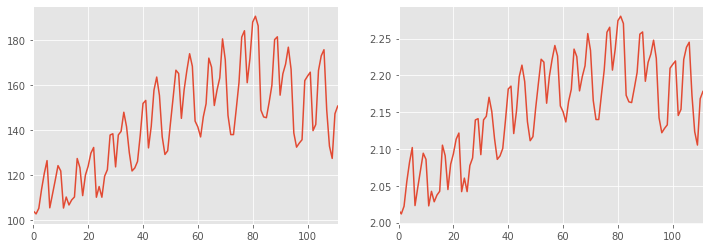

In [12]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['x2'].plot(ax=ax1)
#  ax1.set_title(u'Объём пассажироперевозок')
#  ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['x2'])).plot(ax=ax2)
#  ax2.set_title(u'log10 от объёма пассажироперевозок')
#  ax2.set_ylabel(u'log10 от тысяч человек')


Вывод: будем строить модель НЕлинейной регрессии для прогнозирования логарифма от объёма перевозок 
$$\log y_i = f(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- характеристики месяца,  $f(x_i)$ -- нелинейная функция харктеристик месяца, $\varepsilon_i$ -- случайный шум.

Создадим первый предиктор модели ```month_num``` -- порядковый номер пары (месяц, год). <br>
Прологарифмируем временной ряд. <br>
Добавим квадраты номеров наблюдений. Вдруг поможет. Тренд ведь нелинейный...

In [13]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['x2'])
df['month_num_2'] = df['month_num']**2



In [14]:
#  все нормально?
df.head()

,x2,month_num,log_y,month_num_2
0,104.04,1,2.017200,1
1,102.74,2,2.011740,4
2,105.23,3,2.022140,9
3,113.63,4,2.055493,16
4,120.77,5,2.081959,25


In [16]:
#  все нормально?
df.tail()

,x2,month_num,log_y,month_num_2
107,148.95,108,2.173041,11664
108,132.89,109,2.123492,11881
109,127.44,110,2.105306,12100
110,147.32,111,2.168262,12321
111,150.72,112,2.178171,12544


In [17]:
#  все нормально?
df['log_y'][0]

2.017200343523835

In [18]:
#  Предсказываем логарифм, поэтому исходный ряд не нужен
#  Даты не используем, но они были проигнорированы при импорте данных
df_2 = df.drop(columns=["x2"])

In [19]:
#  все нормально?
df_2.head()

,month_num,log_y,month_num_2
0,1,2.017200,1
1,2,2.011740,4
2,3,2.022140,9
3,4,2.055493,16
4,5,2.081959,25


In [20]:
112/12

9.333333333333334

Создадим новые переменные - индикаторы месяцев

In [21]:
df_2["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0]*10)[0:len(df)]
df_2["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0]*10)[0:len(df)]
df_2["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0]*10)[0:len(df)]
df_2["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0]*10)[0:len(df)]
df_2["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0]*10)[0:len(df)]
df_2["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0]*10)[0:len(df)]
df_2["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0]*10)[0:len(df)]
df_2["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0]*10)[0:len(df)]
df_2["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0]*10)[0:len(df)]
df_2["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0]*10)[0:len(df)]
df_2["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0]*10)[0:len(df)]
df_2["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1]*10)[0:len(df)]


In [22]:
#  все нормально?
df_2.head(14)

,month_num,log_y,month_num_2,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,1,2.017200,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2,2.011740,4,0,1,0,0,0,0,0,0,0,0,0,0
2,3,2.022140,9,0,0,1,0,0,0,0,0,0,0,0,0
3,4,2.055493,16,0,0,0,1,0,0,0,0,0,0,0,0
4,5,2.081959,25,0,0,0,0,1,0,0,0,0,0,0,0
5,6,2.101953,36,0,0,0,0,0,1,0,0,0,0,0,0
6,7,2.023088,49,0,0,0,0,0,0,1,0,0,0,0,0
7,8,2.047625,64,0,0,0,0,0,0,0,1,0,0,0,0
8,9,2.071072,81,0,0,0,0,0,0,0,0,1,0,0,0
9,10,2.094226,100,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
#  Создаем матрицу предикторов.
#  На этот раз не надо убирать из нее столбец, соответствующий базовому месяцу
X = df_2.drop(columns=["log_y"])

In [29]:
#  Создаем матрицу (столбец) откликов.
y = df_2['log_y']

In [30]:
#  все нормально?
y.tail()

107    2.173041
108    2.123492
109    2.105306
110    2.168262
111    2.178171
Name: log_y, dtype: float64

In [31]:
#  Случайный лес не может предсказывать ряд с растущим трендом.
#  Будем предсказывать ряд из разностей ряда.
#  Точнее ряд из разностей логарифмов значений исходного ряда.

In [32]:
#  Отклик - разности, еще отбрасываем пропуск

y_2 = y.diff(periods=1).dropna()

In [33]:
#  В матрице предикторов отбрасываем первую строку, там у y_2 появилось NaN

X_2 = X[1:]

In [34]:
#  все нормально?
X_2.head()

,month_num,month_num_2,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
1,2,4,0,1,0,0,0,0,0,0,0,0,0,0
2,3,9,0,0,1,0,0,0,0,0,0,0,0,0
3,4,16,0,0,0,1,0,0,0,0,0,0,0,0
4,5,25,0,0,0,0,1,0,0,0,0,0,0,0
5,6,36,0,0,0,0,0,1,0,0,0,0,0,0


In [35]:
model = RandomForestRegressor(random_state=42,
                               # число деревьев в лесу
                               n_estimators=150,
                               # функция для impurity
                               criterion='mse',
                               # то ли число слоев, то ли число расщеплений  
                               #  ?????????????????  но не число узлов
                               max_depth=10,
                               # сколько переменных использовать при построении дерева?
                               # sqrt(k)
                               max_features=10, 
                               # максимальное число конечных узлов. Сейчас - без ограничений
                               max_leaf_nodes=None,
                               # минимальное уменьшение загрязнения 
                               min_impurity_decrease=0.0, 
                                # Дерево обучается по части наблюдений (По какой???)
                               bootstrap=True, 
                               # минимальное число наблюдений в узле потомке
                               min_samples_leaf=1, 
                               # минимальное число наблюдений в узле родителе
                               min_samples_split=2,
                               # параметр используется редко, самостоятельно
                               min_weight_fraction_leaf=0.0, 
                               # объем промежуточных результатов в ходе обучения
                               verbose=1, 
                               # число используемых процессоров
                               # n_jobs=None,
                               # Вычислять out-of-bag ошибку
                               oob_score=True,
                               # использовать результаты предыдущего вызова и нарастить предыдущий лес 
                               warm_start=False)

model.fit(X_2, y_2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=True, random_state=42, verbose=1,
                      warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


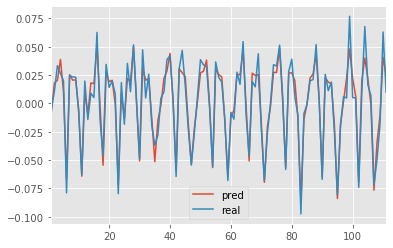

In [36]:
#  Сравним подгонку и ряд разностей

pred = pd.DataFrame({
    'pred': model.predict(X_2),
    'real': y_2})
pred.plot()

In [37]:
#  критерий качества
print("SSE = ", sum((y_2 - model.predict(X_2))**2))

SSE =  0.009162879646978865


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


In [38]:
print(model.predict(X_2))

[-0.00752053  0.01801741  0.02041372  0.03882008  0.01020402 -0.06652522
  0.02532848  0.02060649  0.02070159 -0.00546101 -0.0642039   0.0098638
 -0.0094498   0.01814818  0.01743184  0.05148658 -0.00096325 -0.05453197
  0.02730151  0.01927474  0.02041557 -0.00037426 -0.07165154  0.00948317
 -0.01336934  0.02197976  0.01900226  0.05037624  0.00060365 -0.05067718
  0.03151145  0.02049673  0.02221553 -0.01279666 -0.05139659 -0.01511352
 -0.00165459  0.0221317   0.02866713  0.04415014  0.00146759 -0.05966302
  0.03063228  0.02703268  0.02378519 -0.01767986 -0.05349073 -0.02151357
  0.00128064  0.02694095  0.0284804   0.03827271 -0.00114325 -0.05660966
  0.03002182  0.02555597  0.02336374 -0.01508801 -0.06460349 -0.01224901
 -0.00601818  0.02584631  0.02517288  0.04697943 -0.00267594 -0.05077952
  0.0267017   0.02475276  0.02547013 -0.01780622 -0.06961282 -0.02007462
 -0.00300584  0.02737175  0.02735933  0.04894771  0.00251554 -0.0565625
  0.02682334  0.02702852  0.02024253 -0.012597   -0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


In [39]:
#  От подгонки разностей переходим к подгонке ряда логарифмов

res = model.predict(X_2)
a = [df['log_y'][0]]
for i in res:
    a.append(a[-1] + i)

print(a)



[2.017200343523835, 2.009679808849846, 2.027697218386834, 2.0481109408899596, 2.086931020498745, 2.0971350398402406, 2.03060982155861, 2.055938304624141, 2.07654479437743, 2.097246381411181, 2.091785368922634, 2.027581468159882, 2.037445263919125, 2.0279954681200834, 2.0461436458124496, 2.063575483568514, 2.115062062898398, 2.1140988178229203, 2.0595668514991563, 2.086868365520274, 2.106143101173419, 2.1265586757356907, 2.126184412412488, 2.0545328764171242, 2.064016043846607, 2.0506467077767008, 2.0726264721444525, 2.091628732060869, 2.1420049676684387, 2.1426086222907186, 2.091931441609121, 2.1234428868557753, 2.143939616910146, 2.1661551441421256, 2.153358482028663, 2.1019618941943334, 2.0868483753422518, 2.0851937825309785, 2.1073254829840553, 2.1359926141624967, 2.1801427529050312, 2.1816103380603797, 2.1219473156448387, 2.15257959147273, 2.179612270065955, 2.20339745856667, 2.1857175954986885, 2.1322268622541816, 2.1107132952473817, 2.111993936815629, 2.138934888242379, 2.1674152

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


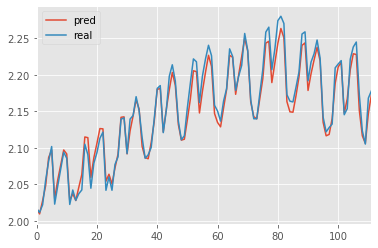

In [40]:
#  Сравним подгонку и ряд

pred = pd.DataFrame({
    'pred': a,
    'real': y})
pred.plot()

In [41]:
pred.head(14)

,pred,real
0,2.017200,2.017200
1,2.009680,2.011740
2,2.027697,2.022140
3,2.048111,2.055493
4,2.086931,2.081959
5,2.097135,2.101953
6,2.030610,2.023088
7,2.055938,2.047625
8,2.076545,2.071072
9,2.097246,2.094226


In [42]:
#  Прогноз на 8 месяцев
horizon = 8


#  Готовим маторицу предикторов для вычисления прогнозов
#  Сначала время
df_3= pd.DataFrame()

df_3['month_num'] = range((len(df)+1), (len(df)+horizon+1))
df_3['month_num_2'] = df_3['month_num']**2

In [46]:
df_3

,month_num,month_num_2
0,113,12769
1,114,12996
2,115,13225
3,116,13456
4,117,13689
5,118,13924
6,119,14161
7,120,14400


In [44]:
len(df)+horizon

120

In [47]:
#  Добавляем индикаторы месяцев. Базовый месяц не удаляем, он не используется
#  Первый месяц пятый!
df_3["m05"] = ([1,0,0,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m06"] = ([0,1,0,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m07"] = ([0,0,1,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m08"] = ([0,0,0,1,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m09"] = ([0,0,0,0,1,0,0,0,0,0,0,0])[0:horizon]
df_3["m10"] = ([0,0,0,0,0,1,0,0,0,0,0,0])[0:horizon]
df_3["m11"] = ([0,0,0,0,0,0,1,0,0,0,0,0])[0:horizon]
df_3["m12"] = ([0,0,0,0,0,0,0,1,0,0,0,0])[0:horizon]
df_3["m01"] = ([0,0,0,0,0,0,0,0,1,0,0,0])[0:horizon]
df_3["m02"] = ([0,0,0,0,0,0,0,0,0,1,0,0])[0:horizon]
df_3["m03"] = ([0,0,0,0,0,0,0,0,0,0,1,0])[0:horizon]
df_3["m04"] = ([0,0,0,0,0,0,0,0,0,0,0,1])[0:horizon]


In [48]:
df_3

,month_num,month_num_2,m05,m06,m07,m08,m09,m10,m11,m12,m01,m02,m03,m04
0,113,12769,1,0,0,0,0,0,0,0,0,0,0,0
1,114,12996,0,1,0,0,0,0,0,0,0,0,0,0
2,115,13225,0,0,1,0,0,0,0,0,0,0,0,0
3,116,13456,0,0,0,1,0,0,0,0,0,0,0,0
4,117,13689,0,0,0,0,1,0,0,0,0,0,0,0
5,118,13924,0,0,0,0,0,1,0,0,0,0,0,0
6,119,14161,0,0,0,0,0,0,1,0,0,0,0,0
7,120,14400,0,0,0,0,0,0,0,1,0,0,0,0


In [49]:
#  Прогноз для разностей
model.predict(df_3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


array([-0.02759325, -0.00499693,  0.03691664,  0.02546867,  0.02420163,
        0.01356916, -0.06891178,  0.02552405])

In [50]:
#  Прогноз для логарфмов
res = model.predict(df_3)
a2 = [df["log_y"][len(df)-1]]
for i in res:
    a2.append(a2[-1] + i)

print(a2)


[2.178170885448802, 2.1505776324995716, 2.145580702253803, 2.182497344586023, 2.207966017423502, 2.2321676429254156, 2.2457368040081063, 2.1768250191715968, 2.2023490736017703]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


In [51]:
#  Прогноз для исходного ряда
y1 = 10**model.predict(df_3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


In [52]:
y1

array([0.93844051, 0.98856008, 1.08872111, 1.06039745, 1.05730826,
       1.03173737, 0.85327342, 1.06053268])

In [53]:
#  матрица с подгонкой
pred['forecast'] = np.nan
pred.head()

,pred,real,forecast
0,2.017200,2.017200,NaN
1,2.009680,2.011740,NaN
2,2.027697,2.022140,NaN
3,2.048111,2.055493,NaN
4,2.086931,2.081959,NaN


In [54]:
#  матрица с прогнозом ()
#  порядок столбцов не важен. Имена столбцов важны - должны быть как выше

#df_4 = pd.DataFrame(model.predict(df_3), columns=['forecast'])
df_4 = pd.DataFrame(a2, columns=['forecast'])
df_4['real'] = np.nan
df_4['pred'] = np.nan
df_4.head()

,forecast,real,pred
0,2.178171,NaN,NaN
1,2.150578,NaN,NaN
2,2.145581,NaN,NaN
3,2.182497,NaN,NaN
4,2.207966,NaN,NaN


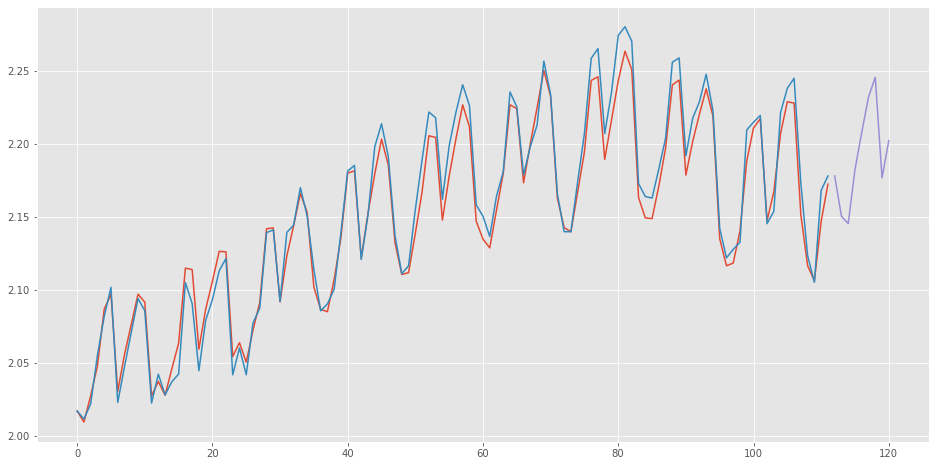

In [55]:
#  объединяем матрицы, задаем новые индексы
pred_1 = pd.concat(
    [pred, df_4],
    sort=False
).reset_index(drop=True)

plt.figure(figsize=(16,8))
#  pred_1.plot()
plt.plot(pred_1)
plt.show()

In [56]:
#  Возвращаемся к исходному ряду
pred_11 = 10**pred_1

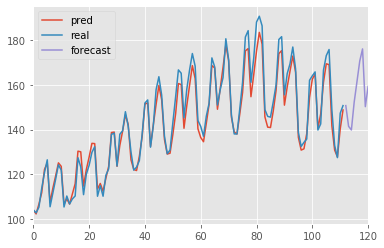

In [57]:
pred_11.plot()